# Compute the Confidence Intervals of Stopping Power
This notebook was created to explore methods for computing a confidence interval in a stopping power calculation.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import BayesianRidge
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import pickle as pkl

## Load the Training Data
Use some of the available training data to explore these calculations

In [2]:
data = pd.read_csv('training_set.csv')

In [3]:
data.sort_values('timestep', inplace=True, ascending=True)

Determine which columns are inputs/outputs

In [4]:
featurizers = pkl.load(open('featurizers.pkl', 'rb'))
X_cols = sum([f.feature_labels() for f in featurizers], [])

In [5]:
y_col = 'force'

## Compute the CI of Running Average
Our first objective is to quantify the uncertainity in the stopping power of a simulation that uses the running average to estimate stopping power

### Method 1: Standard Error of the Mean
The easiest route is to compute the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error#Standard_error_of_the_mean): ${SE}_{\bar{x}} = \sigma / \sqrt{N}$ where $\sigma$ is the standard deviation and $N$ is the number of entries. Conveniently, scipy has a [function for this](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sem.html).

Problem: The above formula assumes that points are randomly sampled. This simulation is *not* a random sample. Perhaps that explains why the SE of mean is bad at first

In [6]:
data['stopping_running-mean'] = [data['force'].iloc[:i].mean() for i in range(len(data))]

In [7]:
data['stopping_running-mean_error'] = [stats.sem(data['force'].iloc[:i]) for i in range(len(data))]

C:\Users\ward6\AppData\Local\Continuum\Miniconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\ward6\AppData\Local\Continuum\Miniconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\ward6\AppData\Local\Continuum\Miniconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plot results

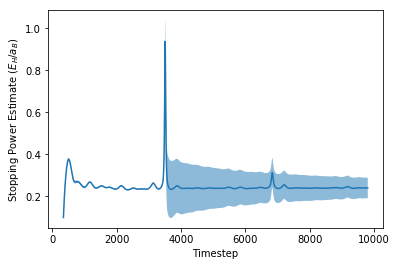

In [8]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['stopping_running-mean'])
ax.fill_between(data['timestep'],
               data['stopping_running-mean'] + data['stopping_running-mean_error'],
               data['stopping_running-mean'] - data['stopping_running-mean_error'],
               alpha=0.5)

ax.set_ylabel('Stopping Power Estimate ($E_H / a_B$)')
ax.set_xlabel('Timestep')

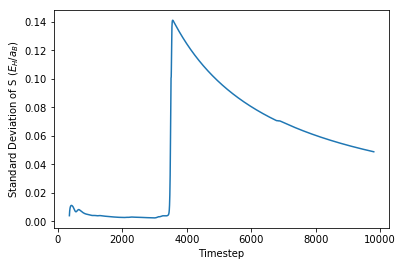

In [9]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['stopping_running-mean_error'])

ax.set_ylabel('Standard Deviation of S ($E_H / a_B$)')
ax.set_xlabel('Timestep')

The standard error of the mean works when the data is normally distributed, and (with the expection of the outliers) this data seems pretty normally-distributed.

*To do*: Find a quantitative question for normality

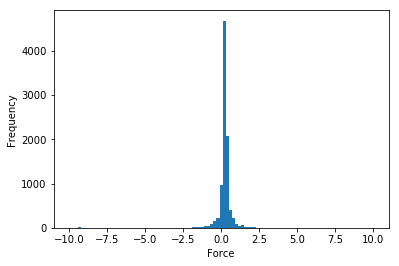

In [10]:
fig, ax = plt.subplots()

ax.hist(data['force'], bins=np.linspace(-10, 10, 100))

ax.set_xlabel('Force')
ax.set_ylabel('Frequency')

## Compute the Confidence Interval of the Bayesian Model
Here, our goal is to get an estimate of the confidence interval of the predictions from the Bayesian regression model. However, the fitness of the model is not perfect and we need a way to take the error of the model into account. 

Here, we assume the error in the stopping power comes from two different sources: finite sampling of the population (see above) and errors resulting from the fitness. Given my limited statistical training, we assume the two errors to be additive [*for now, need to talk to someone with a stronger stats background*]. We can use the same approach above to compute the error of the mean used above, our challenge is then to provide an estimate for the error due to the uncertainty in the ML predictions.

### Approach 1: Compute uncertainity for each force prediction, assume they are uncorrelated
The easiest approach to estimating the confidence interval is to use the variances in each predicted force, which are trivially available from the machine leanring model. We note that the stopping power is computed by: $S = \frac{1}{N} \sum_i y_i$ where $S$ is the stopping power, $N$ is the number of samples, and $y_i$ is the predicted value from the ML model. Using propogation of uncertainities, we can write down: $\sigma_S^2 = \frac{1}{N^2} \sum_i \sigma_{y_i}^2$. So, the uncertainity in the prediction is equal to the average uncertainity in the ML predictions, that is:  $\sigma_S = \frac{1}{N} \sum_i \sigma_{y_i}$

*To do*: Forecast out farther than 10k timesteps with ML model. Reduces the first part of the error

Test out computing uncertainties

In [11]:
model = BayesianRidge(normalize=True)
model.fit(data[X_cols].iloc[:10], data[y_col].iloc[:10])

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False)

In [12]:
data['force_ml'], data['force_ml_var'] = model.predict(data[X_cols], True)

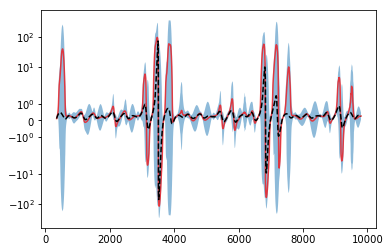

In [13]:
fig, ax = plt.subplots() 

ax.plot(data['timestep'], data['force_ml'], 'r-', alpha=0.7)
ax.plot(data['timestep'], data['force'], 'k--')
ax.fill_between(data['timestep'], data['force_ml'] + data['force_ml_var'],
                data['force_ml'] - data['force_ml_var'], alpha=0.5)

ax.set_yscale('symlog')
ax.set_yscale('symlog')

In [14]:
def compute_ml_stopping_power(train_data, run_data):
    """Computes the stopping power using ML, includes uncertainties
    
    :param train_data: DataFrame, data used to train the model
    :param run_data: DataFrame, trajectory over which to evaluate model and, thereby, compute stopping power"""
    
    # Fit the model
    model = BayesianRidge(normalize=True).fit(train_data[X_cols], train_data[y_col])
    
    # Run the model on the run data
    force, force_std = model.predict(run_data[X_cols], True)
    
    # Compute the mean, error
    return force.mean(), np.sqrt(stats.sem(force) ** 2 + force_std.mean() ** 2)

In [15]:
results = [ compute_ml_stopping_power(data[data['timestep'] <= x['timestep']], data) for i,x in tqdm(list(data.iterrows())) ]
data['stopping_ml'], data['stopping_ml_error'] = list(zip(*results))
del results

C:\Users\ward6\AppData\Local\Continuum\Miniconda3\lib\site-packages\sklearn\linear_model\bayes.py:165: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_ = 1. / np.var(y)
C:\Users\ward6\AppData\Local\Continuum\Miniconda3\lib\site-packages\sklearn\linear_model\bayes.py:197: RuntimeWarning: divide by zero encountered in true_divide
  U / (eigen_vals_ + lambda_ / alpha_)[None, :], U.T))
C:\Users\ward6\AppData\Local\Continuum\Miniconda3\lib\site-packages\sklearn\linear_model\bayes.py:211: RuntimeWarning: invalid value encountered in multiply
  gamma_ = (np.sum((alpha_ * eigen_vals_) /
C:\Users\ward6\AppData\Local\Continuum\Miniconda3\lib\site-packages\sklearn\linear_model\bayes.py:212: RuntimeWarning: invalid value encountered in multiply
  (lambda_ + alpha_ * eigen_vals_)))


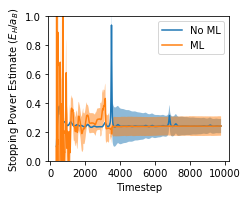

In [16]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['stopping_running-mean'], label='No ML')
ax.fill_between(data['timestep'],
               data['stopping_running-mean'] + data['stopping_running-mean_error'],
               data['stopping_running-mean'] - data['stopping_running-mean_error'],
               alpha=0.5)

ax.plot(data['timestep'], data['stopping_ml'], label='ML')
ax.fill_between(data['timestep'],
               data['stopping_ml'] + data['stopping_ml_error'],
               data['stopping_ml'] - data['stopping_ml_error'],
               alpha=0.5)

ax.legend()
ax.set_ylim(0,1)

ax.set_ylabel('Stopping Power Estimate ($E_H / a_B$)')
ax.set_xlabel('Timestep')

fig.tight_layout()
fig.set_size_inches(3, 2.5)

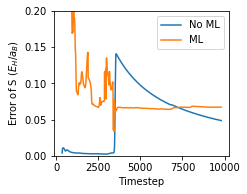

In [17]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['stopping_running-mean_error'], label='No ML')
ax.plot(data['timestep'], data['stopping_ml_error'], label='ML')

ax.set_ylim(0, 0.2)
ax.legend()

ax.set_ylabel('Error of S ($E_H / a_B$)')
ax.set_xlabel('Timestep')

fig.tight_layout()
fig.set_size_inches(3, 2.5)